In [1]:
from scipy.stats import dirichlet
from scipy.special import kl_div
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets

import os

In [2]:
# データセット可視化メソッド
def plot_data(X_train, y_train, name):
    plt.figure(figsize=(12,5))

    # true
    # plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name}')

    plt.tight_layout()
    plt.show()

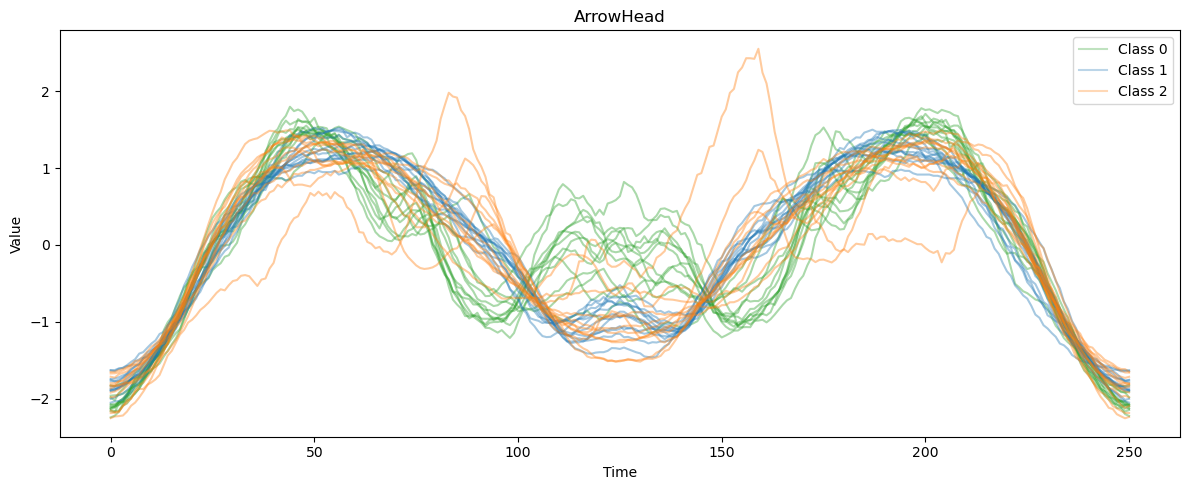

In [3]:
data_name = 'ArrowHead'

# データセットの読み込み（ここではUCR/UEAデータセットを使用）
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)

plot_data(X_train, y_train, data_name)

In [4]:
y_train

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

trainデータの形状確認

In [5]:
X_train[:,:,0].shape

(36, 251)

trainデータ全体の頻度分布をからbinsの設定を取得

In [6]:
hist, bin_edges = np.histogram(X_train[:,:,0].T, bins='auto', density=False)
print('hist:', hist,'\nbin_edges:', bin_edges)

bin_max = bin_edges.max()
bin_min = bin_edges.min()
bin_num = len(hist)

print('bin_max:', bin_max, '\nbin_min:', bin_min, '\nbin_num:', bin_num)

hist: [ 59 114 214 237 240 210 386 508 491 486 379 354 385 420 435 414 433 439
 502 622 737 541 346  56  15   5   1   3   4] 
bin_edges: [-2.2570801  -2.09118071 -1.92528131 -1.75938192 -1.59348253 -1.42758313
 -1.26168374 -1.09578435 -0.92988496 -0.76398556 -0.59808617 -0.43218678
 -0.26628738 -0.10038799  0.0655114   0.2314108   0.39731019  0.56320958
  0.72910898  0.89500837  1.06090776  1.22680716  1.39270655  1.55860594
  1.72450533  1.89040473  2.05630412  2.22220351  2.38810291  2.5540023 ]
bin_max: 2.5540023 
bin_min: -2.2570801 
bin_num: 29


上記のbins設定でtraiｎデータ全体を頻度分布に変換

In [7]:
hist_li = []
for d in range(X_train.shape[0]):
    hist_ = np.histogram(X_train[d], bins=bin_num, range=(bin_min, bin_max), density=False)[0] + 0.000001
    hist_li.append(hist_ / hist_.sum()) # 合計を１にスケール

X_hist = np.array(hist_li)
X_hist

array([[3.98406328e-09, 1.59362571e-02, 3.98406368e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 1.99203204e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 4.38247001e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       ...,
       [1.19521938e-02, 2.78884470e-02, 1.59362571e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 3.98406368e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 2.78884470e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09]])

In [8]:
X_hist.shape

(36, 29)

In [9]:
X_hist[0]

array([3.98406328e-09, 1.59362571e-02, 3.98406368e-02, 2.39043837e-02,
       2.39043837e-02, 1.19521938e-02, 1.59362571e-02, 1.19521938e-02,
       4.38247001e-02, 1.23505966e-01, 1.23505966e-01, 4.78087634e-02,
       2.78884470e-02, 2.39043837e-02, 1.59362571e-02, 4.78087634e-02,
       5.57768900e-02, 4.78087634e-02, 4.78087634e-02, 4.38247001e-02,
       5.17928267e-02, 4.38247001e-02, 1.11553776e-01, 3.98406328e-09,
       3.98406328e-09, 3.98406328e-09, 3.98406328e-09, 3.98406328e-09,
       3.98406328e-09])

In [10]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [15]:
import pymc as pm
import arviz as az
print('version.', pm.__version__)
from pytensor import tensor as pt

version. 5.8.0


### 複数クラスに対するパラメータ推定

モデル定義

In [12]:
data_ = X_hist
data_

array([[3.98406328e-09, 1.59362571e-02, 3.98406368e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 1.99203204e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 4.38247001e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       ...,
       [1.19521938e-02, 2.78884470e-02, 1.59362571e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 3.98406368e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 2.78884470e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09]])

In [13]:
data_.sum()

36.0

In [50]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

K = 2

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    a = pm.Gamma('a', 1., 1.)
    w = pm.StickBreakingWeights('w', alpha=a, K=K-1, dims=('K',))
    label = pm.Categorical('label', p=w, dims=('data',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=1)
    # Dirichlet分布
    result = pm.Dirichlet("obs", a=alpha_[label], observed=x, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

In [98]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]
def stick_breaking_DP(a, K):
    b = pm.Beta('B', 1., a, shape=K)
    w = b * pm.math.concatenate([[1.], pt.extra_ops.cumprod(1. - b)[:-1]])
    return w/w.sum()

K = 2

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    # a = pm.Gamma('a', 100, 1)
    a = pm.Uniform('a', lower=0.01, upper=100)
    w = pm.Deterministic('w', stick_breaking_DP(a, K))
    label = pm.Categorical('label', p=w, dims=('data',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=100)
    # Dirichlet分布
    result = pm.Dirichlet("obs", a=alpha_[label], observed=x, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

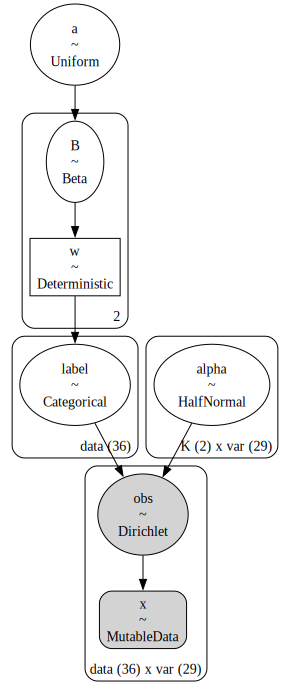

In [99]:
# 構造
modeldag = pm.model_to_graphviz(model_dirichlet)
display(modeldag)


In [73]:
model_dirichlet.debug()

point={'a_log__': array(0.), 'B_logodds__': array([0., 0.]), 'label': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'alpha_log__': array([[4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019],
       [4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019

In [100]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=1, #nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [a, B, alpha]
>BinaryGibbsMetropolis: [label]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 14.4 s, sys: 394 ms, total: 14.8 s
Wall time: 24.8 s


numpyroをサンプラーで指定したら、モデルが連続的でないためエラーが出た

In [34]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Max rhat: nan


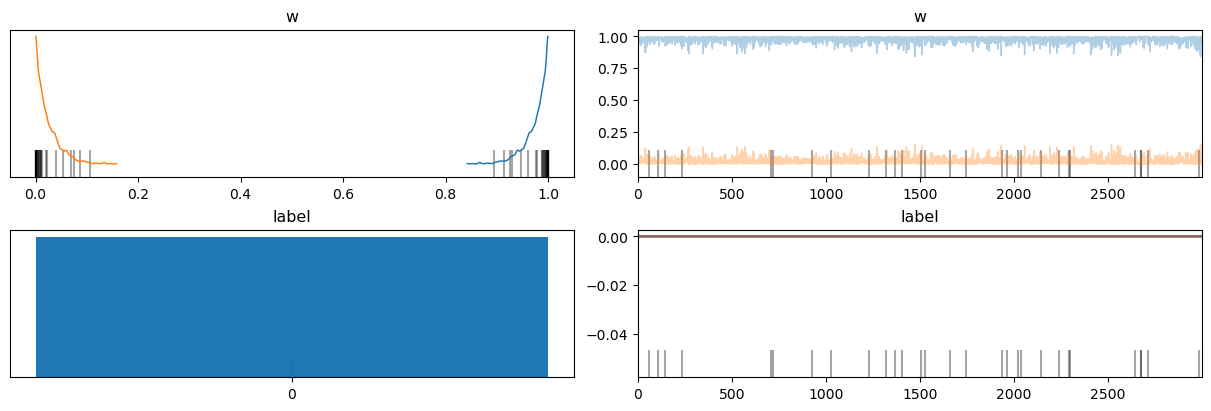

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (58) in plot_posterior, generating only 40 plots
  warnings.warn(


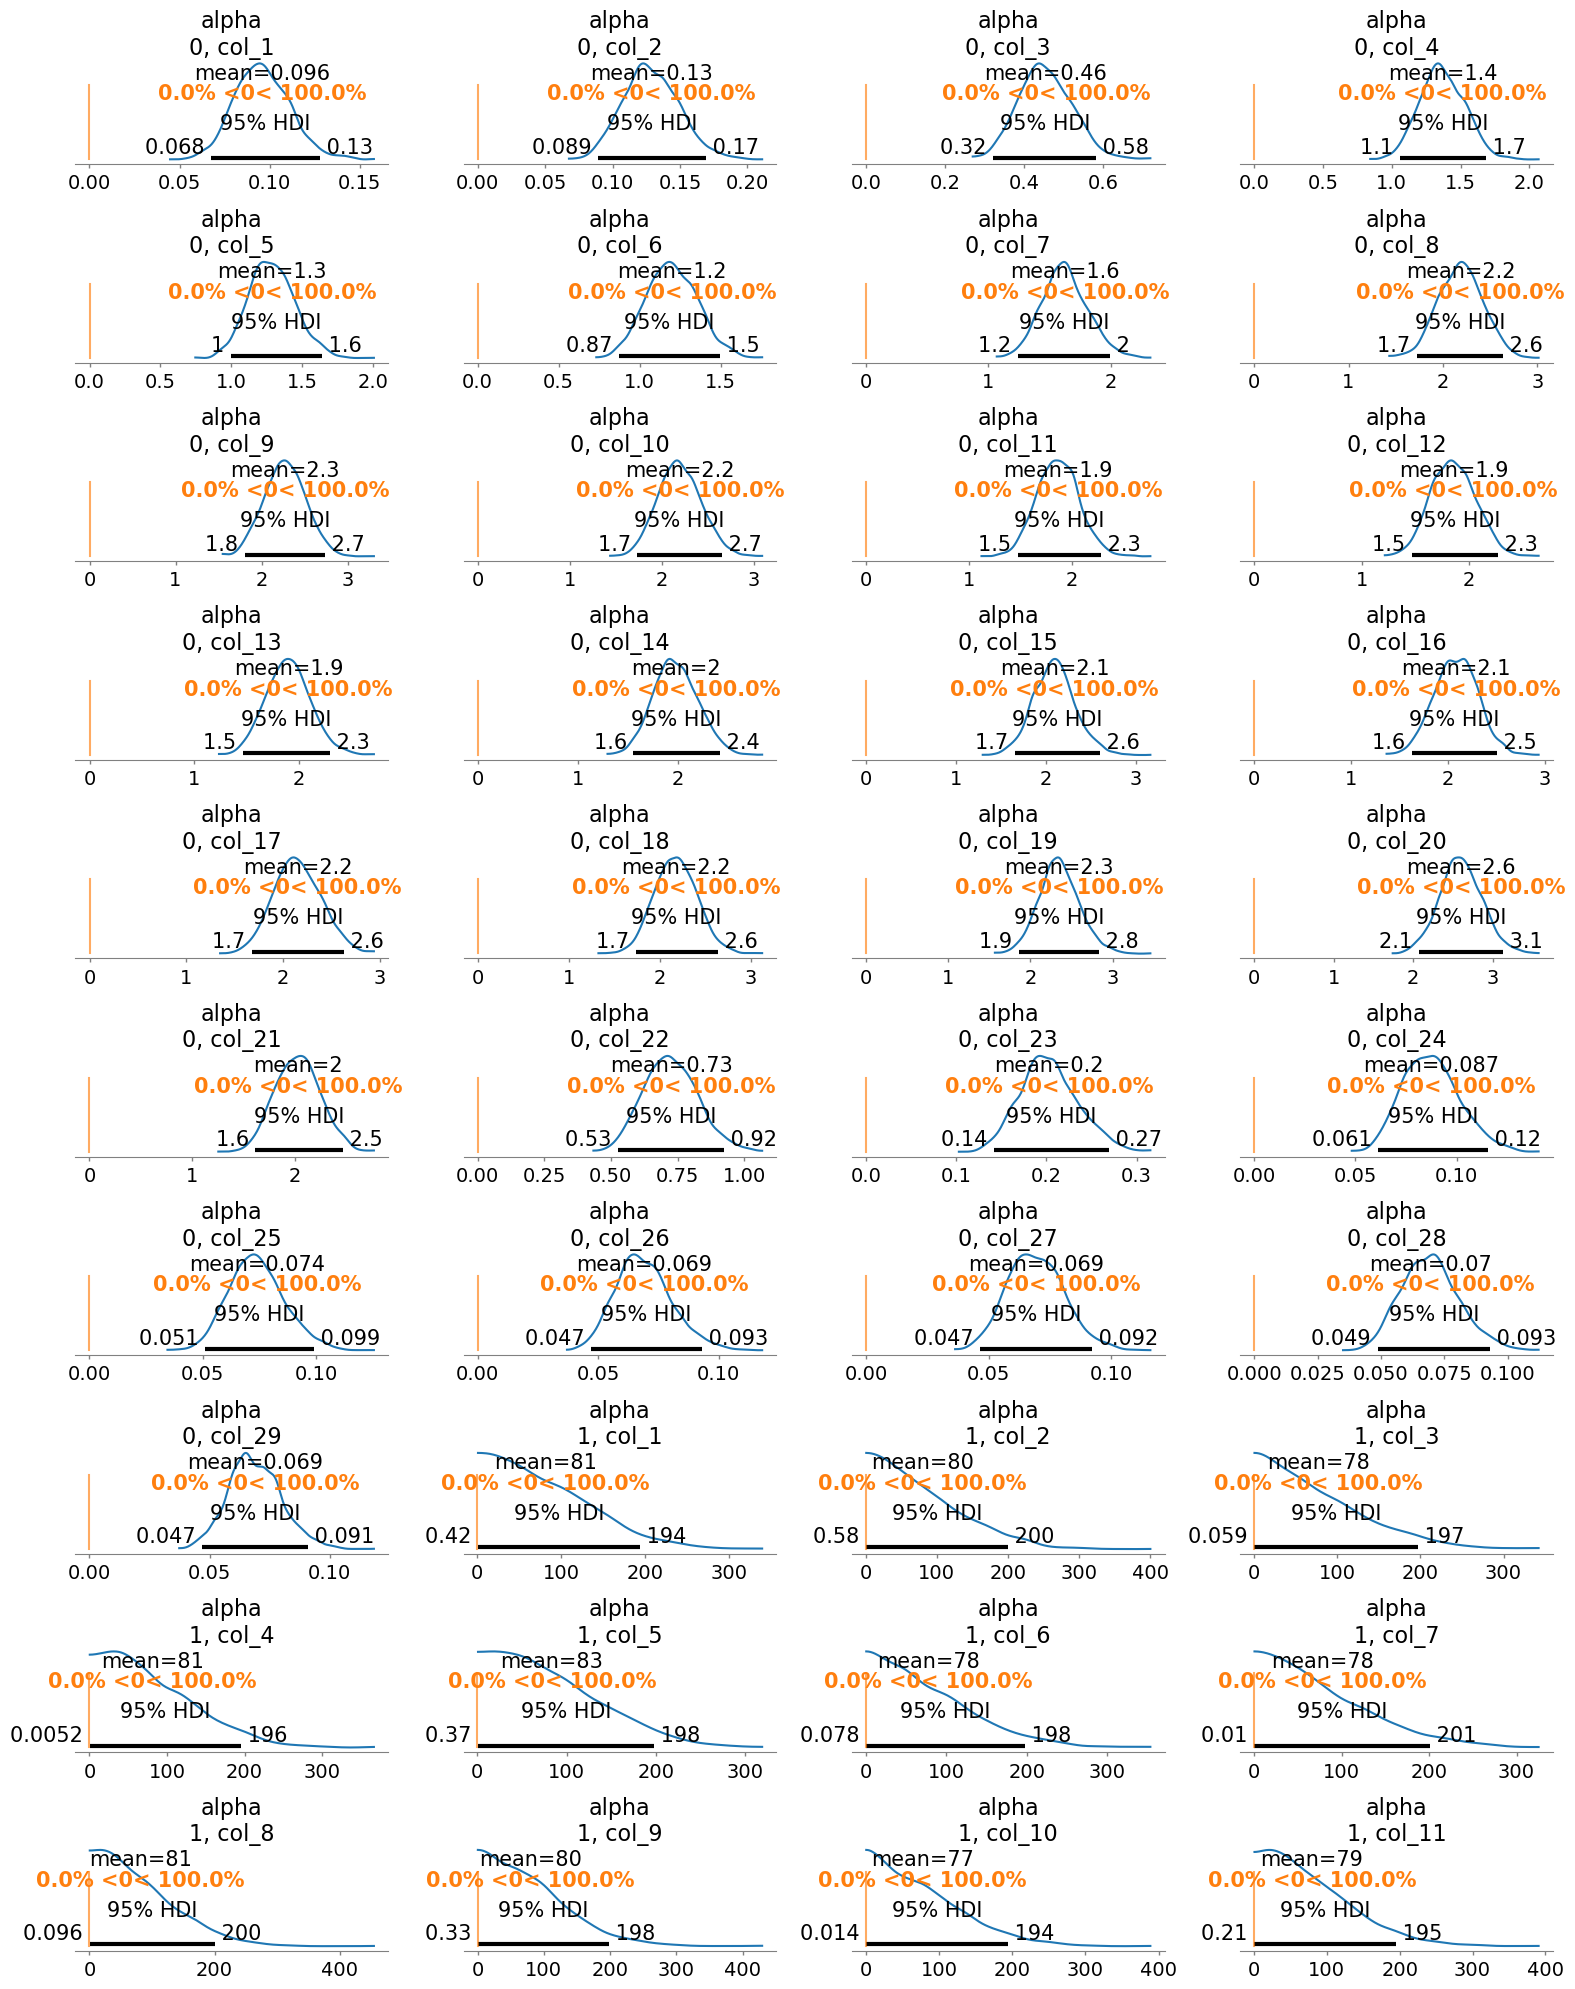

In [101]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['w']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['w','label'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


In [102]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
# df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
# df_summary['alpha_normal']
df_summary

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
label[0],0.000,0.000,0.000,0.000,0.000,0.000,3000.0,3000.0,NaN
label[1],0.000,0.000,0.000,0.000,0.000,0.000,3000.0,3000.0,NaN
label[2],0.000,0.000,0.000,0.000,0.000,0.000,3000.0,3000.0,NaN
label[3],0.000,0.000,0.000,0.000,0.000,0.000,3000.0,3000.0,NaN
label[4],0.000,0.000,0.000,0.000,0.000,0.000,3000.0,3000.0,NaN
...,...,...,...,...,...,...,...,...,...
"alpha[1, col_27]",81.003,60.506,0.132,186.719,1.116,0.789,1924.0,983.0,NaN
"alpha[1, col_28]",80.866,58.527,0.093,183.847,1.230,0.870,1646.0,892.0,NaN
"alpha[1, col_29]",78.109,61.905,0.035,191.969,1.468,1.038,1028.0,468.0,NaN
w[0],0.975,0.024,0.932,1.000,0.001,0.000,1224.0,815.0,NaN


In [69]:
df_summary['r_hat'].unique()

array([nan])

In [ ]:
df_summary['alpha_normal']

In [ ]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_.mean(axis=0), color='blue', alpha=0.5, label='true_mean')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_summary['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

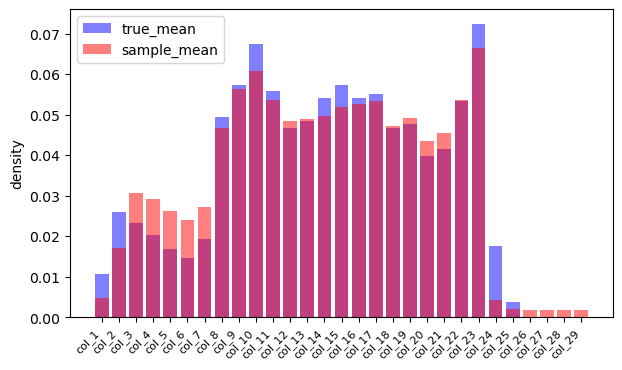

In [188]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_.mean(axis=0), color='blue', alpha=0.5, label='true_mean')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_summary['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

事前分布のシグマを100に変更

In [189]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('var',), sigma=100)
    # Dirichlet分布
    result = pm.Dirichlet("obs", a=alpha_, observed=x, dims=('data','var'))
    # # likelihood
    # result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))

# 定義した各パラメータの情報
display(model_dirichlet.model)

In [190]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

Compiling...
Compilation time =  0:00:00.275721
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:01<00:00, 3057.08it/s]

Sampling time =  0:00:01.358585
Transforming variables...
Transformation time =  0:00:00.003834
CPU times: user 2.18 s, sys: 58.7 ms, total: 2.24 s
Wall time: 2.1 s


Max rhat: 1.0014017011567025


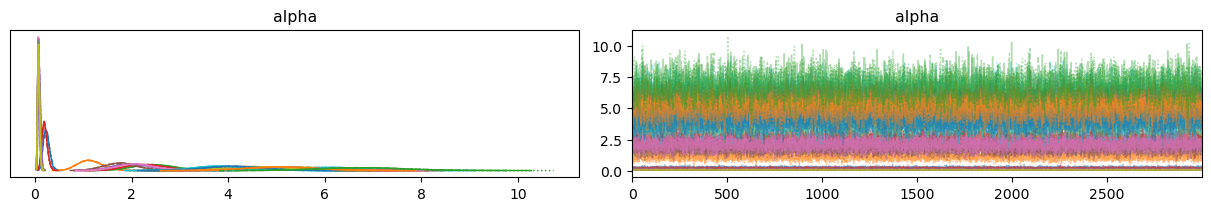

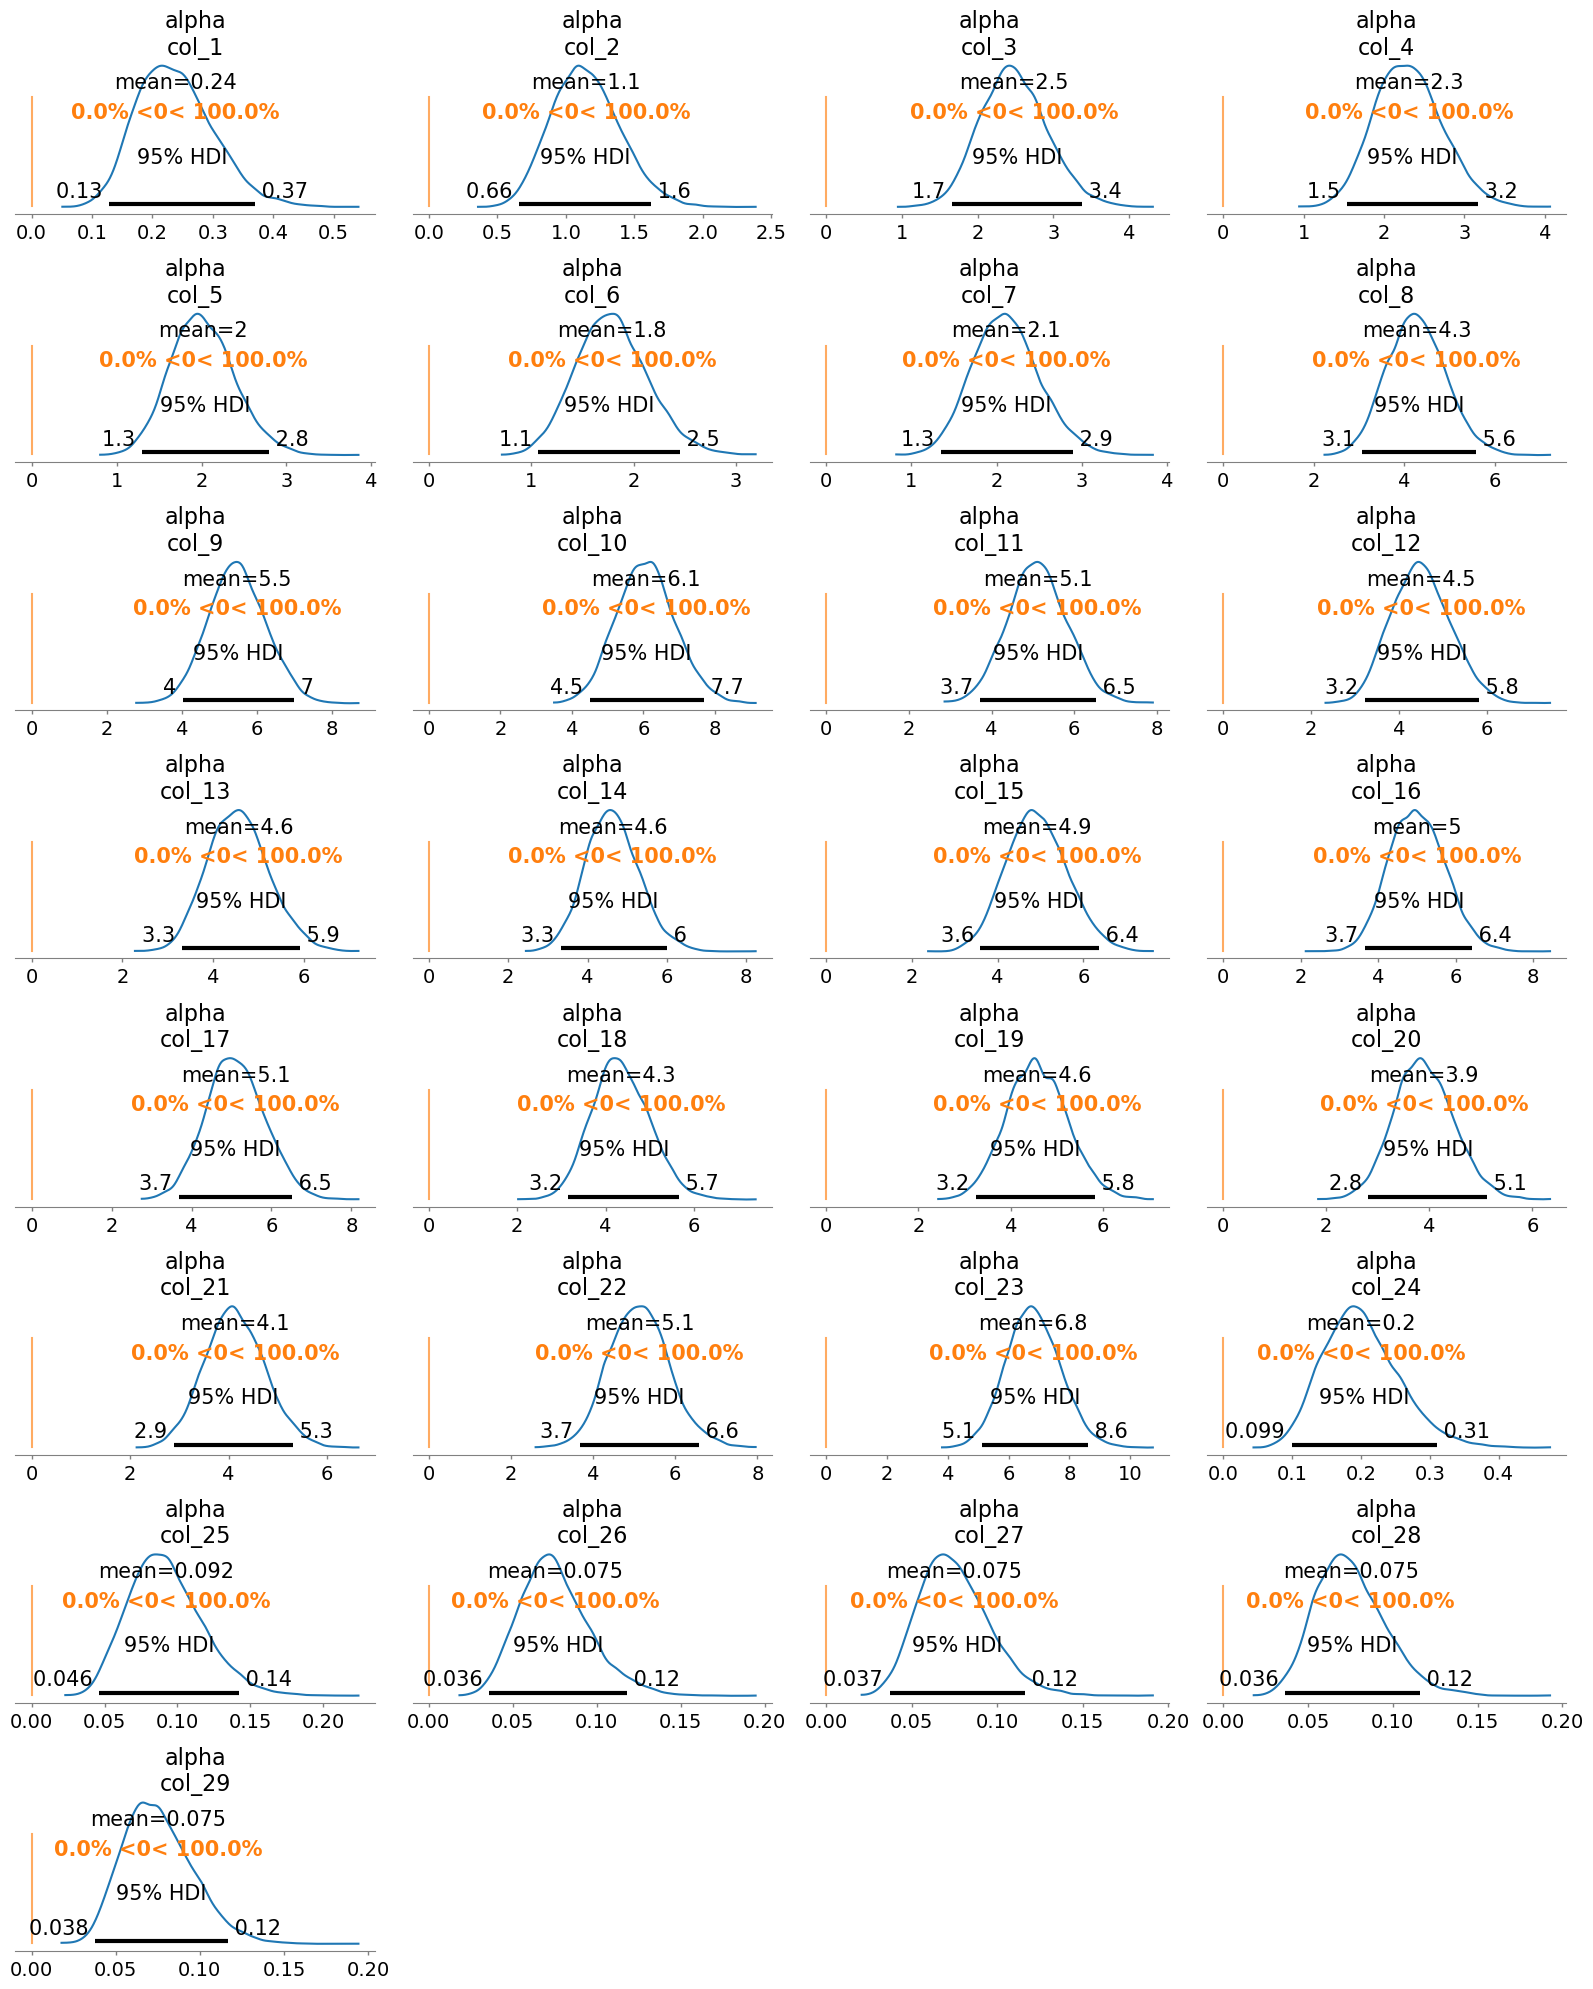

In [191]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['alpha']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['alpha'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


In [192]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
df_summary['alpha_normal']
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,alpha_normal
alpha[col_1],0.238,0.064,0.131,0.363,0.001,0.000,13925.0,6923.0,1.0,0.002610
alpha[col_2],1.148,0.251,0.679,1.608,0.003,0.002,9744.0,7019.0,1.0,0.012587
alpha[col_3],2.479,0.442,1.675,3.315,0.005,0.004,7232.0,6335.0,1.0,0.027181
alpha[col_4],2.307,0.421,1.543,3.110,0.005,0.003,7371.0,6450.0,1.0,0.025295
alpha[col_5],2.016,0.381,1.310,2.739,0.004,0.003,8659.0,5599.0,1.0,0.022104
alpha[col_6],1.791,0.353,1.160,2.486,0.004,0.003,8730.0,5726.0,1.0,0.019637
alpha[col_7],2.113,0.397,1.384,2.875,0.005,0.003,7423.0,5964.0,1.0,0.023168
alpha[col_8],4.273,0.647,3.050,5.459,0.009,0.006,5074.0,5493.0,1.0,0.046851
alpha[col_9],5.467,0.762,4.111,6.966,0.011,0.008,4541.0,6093.0,1.0,0.059942
alpha[col_10],6.069,0.817,4.551,7.616,0.012,0.009,4565.0,6181.0,1.0,0.066542


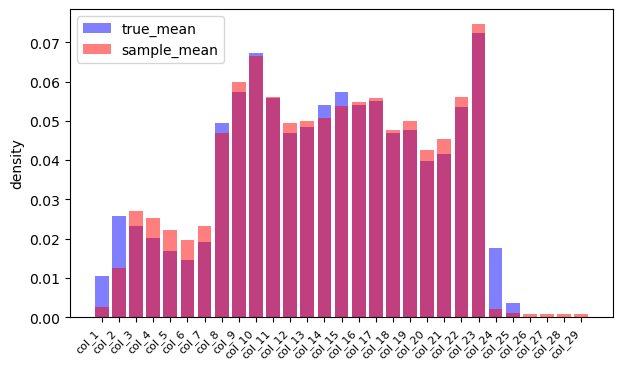

In [193]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_.mean(axis=0), color='blue', alpha=0.5, label='true_mean')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_summary['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示